In [34]:
from kornia import feature
import torchvision
import torch
from matplotlib import pyplot as plt
import matplotlib
import cv2

In [27]:
def make_matching_figure(
        img0, img1, mkpts0, mkpts1, color,
        kpts0=None, kpts1=None, text=[], dpi=75, path=None):
    # draw image pair
    assert mkpts0.shape[0] == mkpts1.shape[0], f'mkpts0: {mkpts0.shape[0]} v.s. mkpts1: {mkpts1.shape[0]}'
    fig, axes = plt.subplots(1, 2, figsize=(10, 6), dpi=dpi)
    axes[0].imshow(img0, cmap='gray')
    axes[1].imshow(img1, cmap='gray')
    for i in range(2):   # clear all frames
        axes[i].get_yaxis().set_ticks([])
        axes[i].get_xaxis().set_ticks([])
        for spine in axes[i].spines.values():
            spine.set_visible(False)
    plt.tight_layout(pad=1)
    
    if kpts0 is not None:
        assert kpts1 is not None
        axes[0].scatter(kpts0[:, 0], kpts0[:, 1], c='w', s=2)
        axes[1].scatter(kpts1[:, 0], kpts1[:, 1], c='w', s=2)

    # draw matches
    if mkpts0.shape[0] != 0 and mkpts1.shape[0] != 0:
        fig.canvas.draw()
        transFigure = fig.transFigure.inverted()
        fkpts0 = transFigure.transform(axes[0].transData.transform(mkpts0))
        fkpts1 = transFigure.transform(axes[1].transData.transform(mkpts1))
        fig.lines = [matplotlib.lines.Line2D((fkpts0[i, 0], fkpts1[i, 0]),
                                            (fkpts0[i, 1], fkpts1[i, 1]),
                                            transform=fig.transFigure, c=color[i], linewidth=1)
                                        for i in range(len(mkpts0))]
        
        axes[0].scatter(mkpts0[:, 0], mkpts0[:, 1], c=color, s=4)
        axes[1].scatter(mkpts1[:, 0], mkpts1[:, 1], c=color, s=4)

    # put txts
    txt_color = 'k' if img0[:100, :200].mean() > 200 else 'w'
    fig.text(
        0.01, 0.99, '\n'.join(text), transform=fig.axes[0].transAxes,
        fontsize=15, va='top', ha='left', color=txt_color)

    # save or return figure
    if path:
        plt.savefig(str(path), bbox_inches='tight', pad_inches=0)
        plt.close()
    else:
        return fig

In [4]:
loftr = feature.LoFTR(pretrained="indoor")

In [35]:
image_pair = ("../debug_track/0_render.png", "../debug_track/100_gt.png")
render = torchvision.io.read_image(image_pair[0], mode=torchvision.io.ImageReadMode.GRAY).unsqueeze(0) / 255.0
gt = torchvision.io.read_image(image_pair[1], mode=torchvision.io.ImageReadMode.GRAY).unsqueeze(0) / 255.0
render_raw = cv2.imread(image_pair[0], cv2.IMREAD_GRAYSCALE)
gt_raw = cv2.imread(image_pair[1], cv2.IMREAD_GRAYSCALE)

In [43]:
input = {"image0": render, "image1": gt}
out = loftr(input)

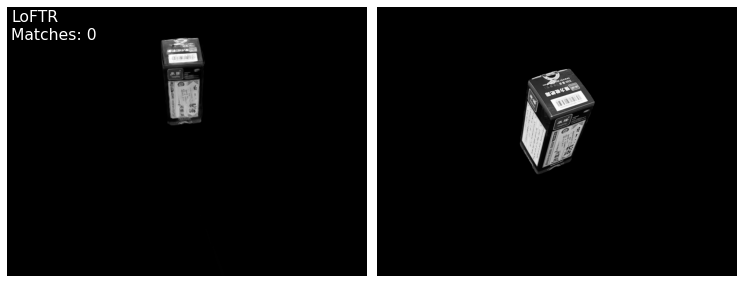

In [44]:
color = matplotlib.cm.jet(out["confidence"], alpha=0.7)
text = [
    'LoFTR',
    'Matches: {}'.format(len(out['keypoints0'])),
]
fig = make_matching_figure(render_raw, gt_raw, out['keypoints0'], out['keypoints0'], color=color, kpts0=out['keypoints0'], kpts1=out['keypoints1'], text=text)

In [45]:
out['keypoints0']

tensor([], size=(0, 2))